1. 删掉 ST
2. 删掉业绩亏损
3. 删掉净资产为负
4. 选取市盈率前 200 名
5. 选取市净率 200 名
6. MA-5 > MA - 21 且缺口变大 $\Rightarrow$ 可能会继续向上 || MA-21 > MA-5 且缺口变小 $\Rightarrow$ 可能会金叉

In [1]:
import tushare as ts
import numpy as np
import datetime
import loess
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as sm_ts_tools
from dateutil.relativedelta import relativedelta
import seaborn as sns

In [2]:
## Set up the date
today = '20' + datetime.date.today().strftime('%y%m%d')

index_all = ts.get_today_all()

df1 = index_all.copy()  #建立一个备份
n = 200  #选择前n个数据

df1['a']=[('ST' in x )for x in df1.name.astype(str)]  #先给ST股票做标记a
df1=df1.set_index('a')  #将a设置为索引 
df1=df1.drop(index=[True]) #删除ST股票
df1=df1.reset_index(drop=True) #重建默认索引

#删除业绩亏损的股票
df1 = df1[df1.per >0]

#删除净资产为负的股票
df1 = df1[df1.pb >0]

#选取市盈率前 200 名股票
df2 = df1.sort_values(by=['per'],ascending=True).head(n)
#print(len(df2))
#选取市净率 200 名股票
df3 = df1.sort_values(by=['pb'],ascending=True).head(n)
#print(len(df3))
#生成股票代码集合，进行集合运算
g2 = set(df2.code) #低市盈率股票代码
#print(len(g2))
g3 = set(df3.code) #低市净率股票代码
#print(len(g3))
g = g2&g3 #集合交运算
#print(len(g))
pending_list = list(g)  #把集合转为列表
print('Basic Selection:',pending_list, "Totally:", len(pending_list))

pending_list_csv = pd.DataFrame({"Code":pending_list})
pending_list_csv.to_csv("pending_list.csv")

In [7]:
# Comparing MA-5 & MA-21
# MA-5 ts.get_hist_data(pending_list[i])['close'].rolling(5).mean().shift(-4) 
# MA-21 ts.get_hist_data(pending_list[i])['close'].rolling(21).mean().shift(-20) 


# If MA-5 > MA-21, it is bullrish
# If MA-5 < MA-21, it is bearish

MA_5L_21 = []
MA_21L_5 = []

def MA(code, date):
    return ts.get_hist_data(code)['close'].rolling(date).mean().shift(-date + 1)

from tqdm import tqdm

stock_wanted = []
for i in tqdm(range(0, len(pending_list))):
    MA5_21 = (MA(pending_list[i],5) - MA(pending_list[i], 21)).to_frame()[0:5] 
    MA21_5 = (MA(pending_list[i],21) - MA(pending_list[i], 5)).to_frame()[0:5] 
    # if (dataframe['close'][3] == True) and (dataframe['close'][4] == True):
    if (MA5_21['close'][0] > MA5_21['close'][1]) and (MA5_21['close'][1] > MA5_21['close'][2]) and (MA5_21['close'][2] > MA5_21['close'][3]):
        print("MA(5) > MA(21)", pending_list[i])
        MA_5L_21.append(pending_list[i])
    if (MA21_5['close'][0] > MA21_5['close'][1]) and (MA21_5['close'][1] > MA21_5['close'][2]) and (MA21_5['close'][2] > MA21_5['close'][3]):
        print("MA(21) > MA(5)", pending_list[i])
        MA_21L_5.append(pending_list[i])
print(MA_5L_21)

  1%|          | 1/85 [00:00<01:09,  1.21it/s]

MA(21) > MA(5) 600382


  2%|▏         | 2/85 [00:01<01:09,  1.19it/s]

MA(21) > MA(5) 601390


  4%|▎         | 3/85 [00:02<01:08,  1.19it/s]

MA(21) > MA(5) 000980


  5%|▍         | 4/85 [00:03<01:08,  1.18it/s]

MA(21) > MA(5) 601997


  6%|▌         | 5/85 [00:04<01:07,  1.19it/s]

MA(21) > MA(5) 601699


  7%|▋         | 6/85 [00:05<01:06,  1.19it/s]

MA(21) > MA(5) 600012


  8%|▊         | 7/85 [00:05<01:06,  1.18it/s]

MA(21) > MA(5) 601398


  9%|▉         | 8/85 [00:06<01:05,  1.17it/s]

MA(21) > MA(5) 000825


 11%|█         | 9/85 [00:07<01:04,  1.19it/s]

MA(21) > MA(5) 000732


 12%|█▏        | 10/85 [00:08<01:05,  1.14it/s]

MA(21) > MA(5) 600016


 13%|█▎        | 11/85 [00:09<01:04,  1.14it/s]

MA(21) > MA(5) 600926


 14%|█▍        | 12/85 [00:10<01:03,  1.15it/s]

MA(21) > MA(5) 600019


 16%|█▋        | 14/85 [00:12<01:01,  1.16it/s]

MA(21) > MA(5) 601009


 18%|█▊        | 15/85 [00:12<00:59,  1.17it/s]

MA(21) > MA(5) 000926


 19%|█▉        | 16/85 [00:13<00:58,  1.19it/s]

MA(21) > MA(5) 600569


 20%|██        | 17/85 [00:14<00:56,  1.19it/s]

MA(21) > MA(5) 601166


 21%|██        | 18/85 [00:15<00:55,  1.21it/s]

MA(21) > MA(5) 601588


 22%|██▏       | 19/85 [00:16<00:55,  1.19it/s]

MA(21) > MA(5) 601669


 24%|██▎       | 20/85 [00:17<00:54,  1.20it/s]

MA(5) > MA(21) 600051


 25%|██▍       | 21/85 [00:17<00:52,  1.21it/s]

MA(21) > MA(5) 002133


 26%|██▌       | 22/85 [00:18<00:54,  1.16it/s]

MA(21) > MA(5) 000040


 27%|██▋       | 23/85 [00:19<00:52,  1.18it/s]

MA(21) > MA(5) 000778


 28%|██▊       | 24/85 [00:20<00:53,  1.14it/s]

MA(21) > MA(5) 000039


 31%|███       | 26/85 [00:22<00:49,  1.18it/s]

MA(21) > MA(5) 600000


 32%|███▏      | 27/85 [00:22<00:48,  1.19it/s]

MA(21) > MA(5) 600188


 33%|███▎      | 28/85 [00:23<00:47,  1.20it/s]

MA(21) > MA(5) 601838


 34%|███▍      | 29/85 [00:24<00:40,  1.39it/s]

MA(21) > MA(5) 601077


 35%|███▌      | 30/85 [00:25<00:42,  1.30it/s]

MA(21) > MA(5) 601288


 36%|███▋      | 31/85 [00:26<00:43,  1.25it/s]

MA(21) > MA(5) 600743


 38%|███▊      | 32/85 [00:26<00:42,  1.25it/s]

MA(21) > MA(5) 600269


 39%|███▉      | 33/85 [00:27<00:43,  1.21it/s]

MA(21) > MA(5) 601818


 40%|████      | 34/85 [00:28<00:42,  1.20it/s]

MA(21) > MA(5) 601328


 41%|████      | 35/85 [00:29<00:41,  1.21it/s]

MA(21) > MA(5) 600657


 42%|████▏     | 36/85 [00:30<00:40,  1.22it/s]

MA(21) > MA(5) 002092


 44%|████▎     | 37/85 [00:31<00:41,  1.15it/s]

MA(21) > MA(5) 600919


 45%|████▍     | 38/85 [00:31<00:39,  1.18it/s]

MA(21) > MA(5) 600376


 46%|████▌     | 39/85 [00:32<00:40,  1.15it/s]

MA(21) > MA(5) 600308


 47%|████▋     | 40/85 [00:33<00:38,  1.17it/s]

MA(21) > MA(5) 600859


 48%|████▊     | 41/85 [00:34<00:37,  1.19it/s]

MA(21) > MA(5) 600153


 49%|████▉     | 42/85 [00:35<00:35,  1.21it/s]

MA(21) > MA(5) 601577


 51%|█████     | 43/85 [00:36<00:35,  1.18it/s]

MA(21) > MA(5) 000898


 52%|█████▏    | 44/85 [00:37<00:36,  1.13it/s]

MA(21) > MA(5) 600015


 53%|█████▎    | 45/85 [00:38<00:35,  1.14it/s]

MA(21) > MA(5) 601169


 54%|█████▍    | 46/85 [00:38<00:35,  1.10it/s]

MA(21) > MA(5) 601998


 55%|█████▌    | 47/85 [00:39<00:33,  1.13it/s]

MA(21) > MA(5) 601939


 56%|█████▋    | 48/85 [00:40<00:33,  1.12it/s]

MA(21) > MA(5) 601186


 58%|█████▊    | 49/85 [00:41<00:31,  1.13it/s]

MA(21) > MA(5) 000402


 59%|█████▉    | 50/85 [00:42<00:30,  1.16it/s]

MA(21) > MA(5) 600823


 60%|██████    | 51/85 [00:43<00:28,  1.18it/s]

MA(21) > MA(5) 600348


 61%|██████    | 52/85 [00:44<00:28,  1.17it/s]

MA(21) > MA(5) 600623


 62%|██████▏   | 53/85 [00:44<00:27,  1.17it/s]

MA(21) > MA(5) 603323


 65%|██████▍   | 55/85 [00:46<00:24,  1.20it/s]

MA(21) > MA(5) 601229


 66%|██████▌   | 56/85 [00:47<00:24,  1.18it/s]

MA(21) > MA(5) 600123


 67%|██████▋   | 57/85 [00:48<00:24,  1.15it/s]

MA(21) > MA(5) 601005


 68%|██████▊   | 58/85 [00:49<00:23,  1.16it/s]

MA(21) > MA(5) 601000


 69%|██████▉   | 59/85 [00:50<00:22,  1.18it/s]

MA(21) > MA(5) 600997


 71%|███████   | 60/85 [00:50<00:21,  1.19it/s]

MA(21) > MA(5) 601800


 72%|███████▏  | 61/85 [00:51<00:20,  1.17it/s]

MA(21) > MA(5) 600716


 73%|███████▎  | 62/85 [00:52<00:19,  1.19it/s]

MA(21) > MA(5) 600782


 74%|███████▍  | 63/85 [00:53<00:18,  1.20it/s]

MA(21) > MA(5) 603518


 75%|███████▌  | 64/85 [00:54<00:17,  1.19it/s]

MA(21) > MA(5) 600740


 76%|███████▋  | 65/85 [00:55<00:16,  1.20it/s]

MA(21) > MA(5) 000069


 78%|███████▊  | 66/85 [00:55<00:16,  1.19it/s]

MA(21) > MA(5) 600808


 80%|████████  | 68/85 [00:57<00:14,  1.17it/s]

MA(21) > MA(5) 000900


 81%|████████  | 69/85 [00:58<00:13,  1.17it/s]

MA(21) > MA(5) 600638


 82%|████████▏ | 70/85 [00:59<00:12,  1.20it/s]

MA(21) > MA(5) 300089


 84%|████████▎ | 71/85 [01:00<00:11,  1.20it/s]

MA(21) > MA(5) 601988


 85%|████████▍ | 72/85 [01:00<00:10,  1.20it/s]

MA(21) > MA(5) 600350


 86%|████████▌ | 73/85 [01:01<00:10,  1.18it/s]

MA(21) > MA(5) 600708


 87%|████████▋ | 74/85 [01:02<00:09,  1.17it/s]

MA(21) > MA(5) 002619


 88%|████████▊ | 75/85 [01:03<00:08,  1.17it/s]

MA(21) > MA(5) 601101


 89%|████████▉ | 76/85 [01:04<00:07,  1.16it/s]

MA(21) > MA(5) 000620


 91%|█████████ | 77/85 [01:05<00:06,  1.19it/s]

MA(21) > MA(5) 002936


 92%|█████████▏| 78/85 [01:06<00:05,  1.20it/s]

MA(21) > MA(5) 601828


 93%|█████████▎| 79/85 [01:06<00:04,  1.20it/s]

MA(21) > MA(5) 000415


 94%|█████████▍| 80/85 [01:07<00:04,  1.21it/s]

MA(21) > MA(5) 600971


 96%|█████████▋| 82/85 [01:09<00:02,  1.19it/s]

MA(21) > MA(5) 000959


 98%|█████████▊| 83/85 [01:10<00:01,  1.20it/s]

MA(5) > MA(21) 000791


 99%|█████████▉| 84/85 [01:11<00:00,  1.21it/s]

MA(21) > MA(5) 600067


100%|██████████| 85/85 [01:11<00:00,  1.18it/s]

MA(21) > MA(5) 000709
['600051', '000791']


In [8]:
print(MA_5L_21)
print(MA_21L_5)

['600051', '000791']
['600382', '601390', '000980', '601997', '601699', '600012', '601398', '000825', '000732', '600016', '600926', '600019', '601009', '000926', '600569', '601166', '601588', '601669', '002133', '000040', '000778', '000039', '600000', '600188', '601838', '601077', '601288', '600743', '600269', '601818', '601328', '600657', '002092', '600919', '600376', '600308', '600859', '600153', '601577', '000898', '600015', '601169', '601998', '601939', '601186', '000402', '600823', '600348', '600623', '603323', '601229', '600123', '601005', '601000', '600997', '601800', '600716', '600782', '603518', '600740', '000069', '600808', '000900', '600638', '300089', '601988', '600350', '600708', '002619', '601101', '000620', '002936', '601828', '000415', '600971', '000959', '600067', '000709']


## Locally Weighted Scatter Plot

局部加权回归散点平滑法

In [9]:
def lowess_plot(code_list, time_length):
    while time_length <= 15:
        return print("The prediction is unauthentic, use a longer time period")
    
    for i in range(0, len(code_list)):
        code = code_list[i]
        data = ts.get_hist_data(code).reset_index()

        data.head()

        data_open = np.array(data['open'])
        data_close = np.flipud(np.array(data['close']))
        data_date = np.array(data['date'])
        data_volume = np.array(data['volume'])

        x = range(0, time_length)
        y = data_close[0:time_length]
        y_1 = data_open[0:time_length]
        y_2 = data_volume[0:time_length]
        
        # lowess will return our "smoothed" data with a y value for at every x-value
        lowess = sm.nonparametric.lowess(y, x, frac= 0.3)
        lowess_x = list(zip(*lowess))[0]
        lowess_y = list(zip(*lowess))[1]


        # run scipy's interpolation. There is also extrapolation I believe
        f = interp1d(np.flipud(lowess_x), np.flipud(lowess_y), bounds_error=False)

        xnew = [i/10. for i in range(400)]

        # this this generate y values for our xvalues by our interpolator
        # it will MISS values outsite of the x window (less than 3, greater than 33)
        # There might be a better approach, but you can run a for loop
        #and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
        ynew = f(xnew)

        print("The prediction is not the reality, just for fun!")
        plt.title(code_list[i]+ "Local Regression Simulation")
        plt.plot(x, y, 'o')
        plt.plot(lowess_x, lowess_y, color = "red")
        plt.show()

How low you want to predict: 100
The prediction is not the reality, just for fun!


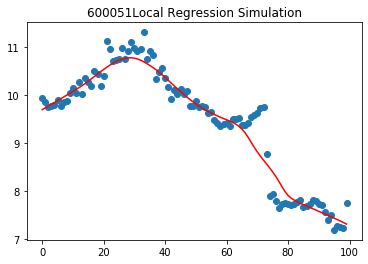

The prediction is not the reality, just for fun!


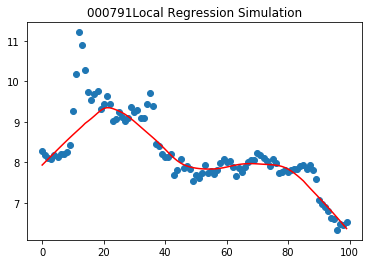

In [15]:
time_length = input("How low you want to predict: ") 
lowess_plot(MA_5L_21, int(time_length))